In [1]:
import pandas as pd
import numpy as np
import re
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Chargement des fichiers
Chargement du petit dataset ne contenant qu'une partie des lignes du dataset original (pour fair les tests et analyse rapidement) et de la liste des colonnes interessantes selon les besoins (Client, Score, Algo)

In [2]:
from listes import *

In [3]:
# Chargement du dataset complet (320772, 162)
#data = pd.read_csv('./data/fr.openfoodfacts.org.products.csv', delimiter='\t', low_memory=False)

In [4]:
# Création d'un extrait du dataset pour charger et expérimenter plus rapidement
#data_petit = data.iloc[np.random.randint(0, len(data), 50000)]
#data_petit.to_csv("./data/data_petit.csv")

In [5]:
# Chargement du dataset version réduite (50000 valeurs pour les tests)
data = pd.read_csv("./data/data_petit.csv", low_memory=False)

On se contente de garder uniquement les colonnes qui nous seront utiles

In [6]:
data = data.loc[:, listeColones]

## Apercu du dataset

In [7]:
data.head()

,code,product_name,image_url,categories,ingredients_text,additives_n,additives,additives_tags,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,...,brands_tags,categories_tags,pnns_groups_1,pnns_groups_2,main_category,main_category_fr,energy-from-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,alcohol_100g
0,4311501391952,Paprika,http://fr.openfoodfacts.org/images/products/43...,Sweet Peppers,"34% Paprika grün, 33% Paprika rot, 33% Paprika...",0.0,[ 34-paprika-grun -> de:34-paprika-grun ] [...,NaN,0.0,NaN,...,edeka,"en:plant-based-foods-and-beverages,en:plant-ba...",Fruits and vegetables,Vegetables,en:fresh-vegetables,Légumes frais,NaN,NaN,NaN,NaN
1,4260140893016,Habañero Käse Kessel Chips,NaN,Kartoffelchips,"Kartoffeln, Sonnenblumenöl, Speisesalz, Zucker...",1.0,[ kartoffeln -> de:kartoffeln ] [ sonnenblu...,en:e330,0.0,NaN,...,pepper-king,"en:salty-snacks,en:appetizers,en:chips-and-fri...",Salty snacks,Appetizers,en:chips-and-fries,Chips et frites,NaN,NaN,NaN,NaN
2,0078742433042,Sweetened Condensed Milk,NaN,NaN,"Milk, sugar",0.0,[ milk -> en:milk ] [ sugar -> en:sugar ],NaN,0.0,NaN,...,great-value,NaN,NaN,NaN,NaN,NaN,NaN,2.56,0.0,NaN
3,6942836700218,HERSHEY'S KISSES 扁桃仁牛奶巧克力,http://fr.openfoodfacts.org/images/products/69...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,hershey-s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0025315248701,"Marie Sharp's, Orange Pulp Habanero Pepper Sau...",NaN,NaN,"Select yellow habanero peppers, orange pulp, o...",0.0,[ select-yellow-habanero-peppers -> en:select...,NaN,0.0,NaN,...,melinda-s-limited,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (50000, 38) :



Type des colonnes :
|                                            | 0       |
|:-------------------------------------------|:--------|
| code                                       | object  |
| product_name                               | object  |
| image_url                                  | object  |
| categories                                 | object  |
| ingredients_text                           | object  |
| additives_n                                | float64 |
| additives                                  | object  |
| additives_tags                             | object  |
| ingredients_from_palm_oil_n                | float64 |
| ingredients_from_palm_oil_tags             | object  |
| ingredients_that_may_be_from_palm_oil_n    | float64 |
| ingredients_that_may_be_from_palm_oil_tags | object  |
| nutrition_grade_fr                         | object  |
| energy_100g                                | float64 |
| fat_100g                    

### Widget pour lire le dataset plus facilement

In [9]:
@interact
def show_describe(column=list(data.columns)):
    return data[column].describe().T

interactive(children=(Dropdown(description='column', options=('code', 'product_name', 'image_url', 'categories…

In [10]:
@interact
def show_extract(column=list(data.columns), x=(0, 300, 1)):
    tmp = data.loc[~data[column].isna(), column]
    return tmp.iloc[x:x+10]

interactive(children=(Dropdown(description='column', options=('code', 'product_name', 'image_url', 'categories…

# Analyse des valeurs manquantes

In [11]:
# Matrice des valeurs manquantes
# msno.matrix(data)

In [12]:
(data['image_url'].isna() & data['categories'].isna()).mean()

0.69136

Diagramme du remplissage de chaque colonne

<AxesSubplot: >

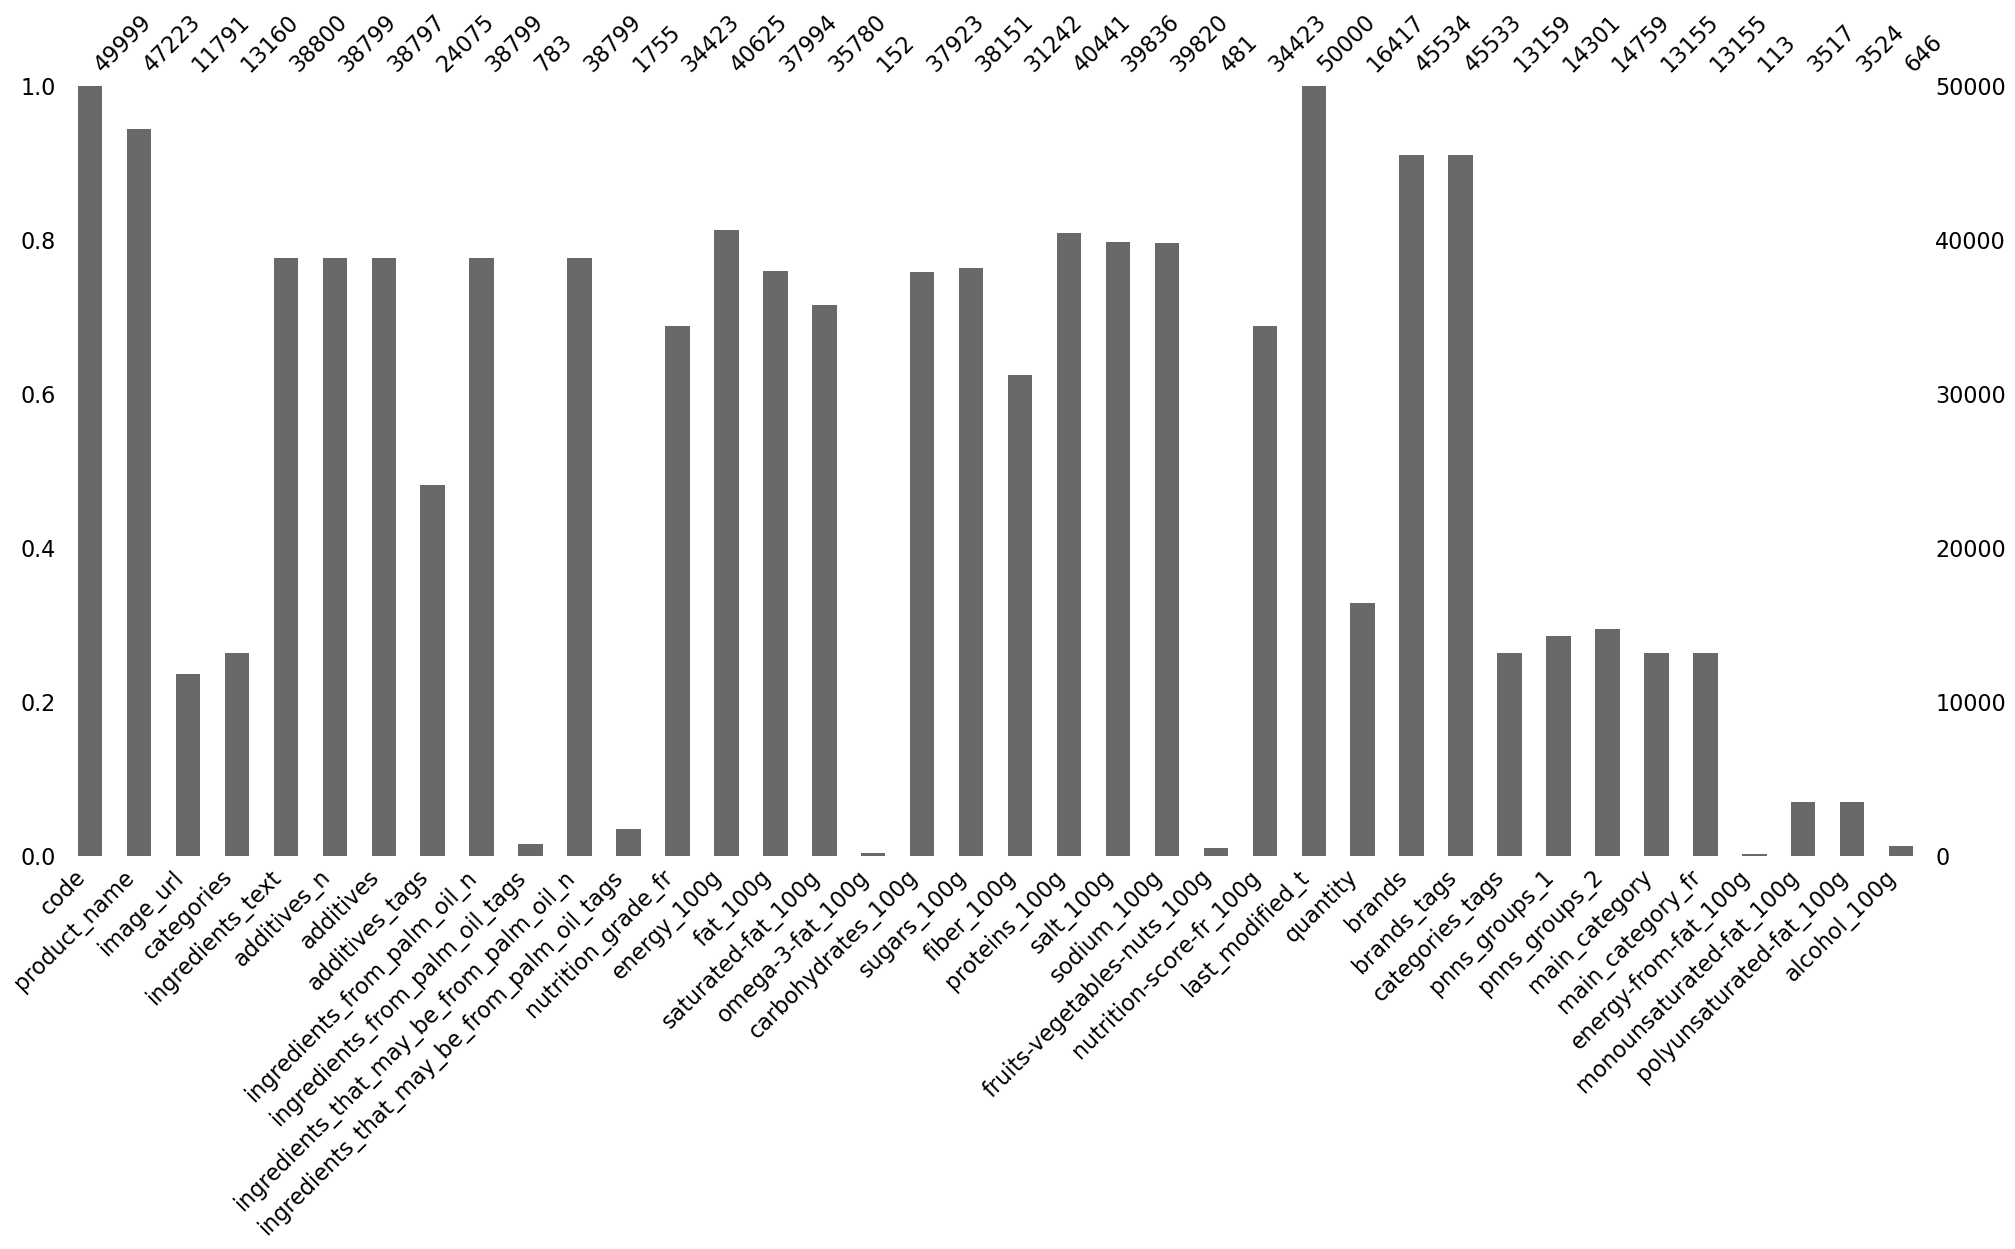

In [13]:
msno.bar(data)

On peut remarquer que beaucoupnde categories sont très vides. Certaines le sont surement car c'est une manière de marquer l'absence de quelquechose (très peu de valeurs dans "ingredients from palm oil" alors que ingredient text est assez remplis, cela signifie peut-être que pour beaucoup, pas de valeur = pas d'ingredients concernés.

Dans l'ensemble, le dataset semble assez bien remplis, surtout si une partie des valeurs peuvent être imputées facilement.

### Dentogramme des liens entre les colonnes

<AxesSubplot: >

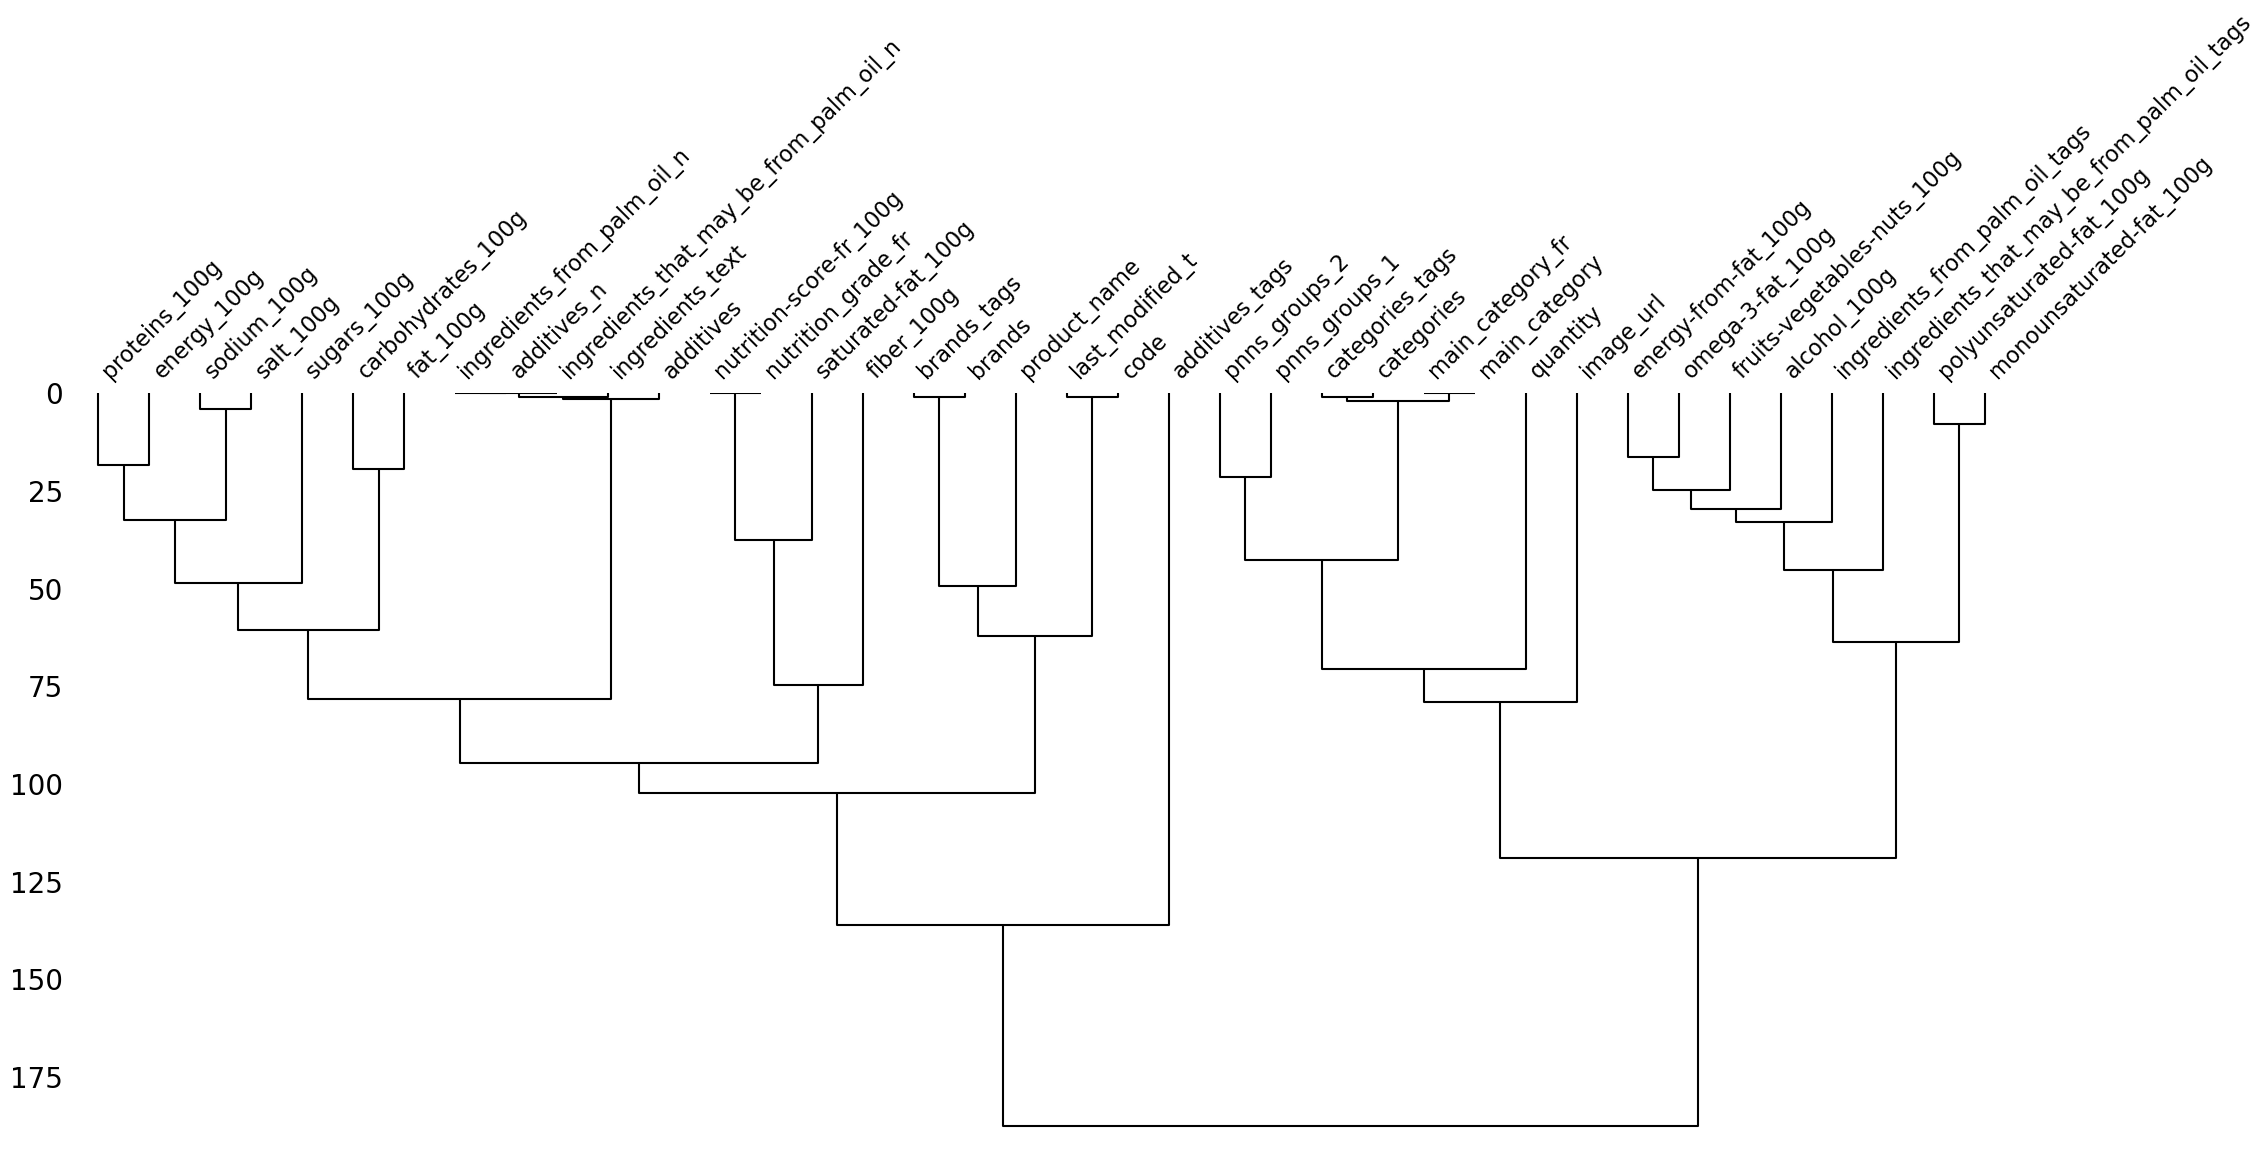

In [14]:
msno.dendrogram(data)

# Analyse des valeurs abérantes

## Suppression des lignes dans les valeurs abérantes pour les codes
Suppression des lignes quand il n'y a pas de code, ou que ce dernier n'est pas correcte (8, 12 ou 13 chiffres), et on ne garde que le code le plus recent

In [15]:
data = data.loc[data['code'].str.len().isin([8,12,13])]

In [16]:
data = data[data['code'].apply(lambda x: str(x).isdigit())]

In [17]:
data = data.sort_values(by='last_modified_t')

nb = len(data)
data = data[~data.duplicated(subset=['code'], keep="last")]

print("On a supprimé " + str(nb - len(data)) + " lignes")

On a supprimé 3637 lignes


In [18]:
print("Tous les codes sont-ils bien uniques?")
print("Oui") if len(data.loc[data['code'].duplicated()]) == 0 else print("Non")

Tous les codes sont-ils bien uniques?
Oui


## Remplacement des unknow par des NaN

In [19]:
data[['pnns_groups_1', 'pnns_groups_2']] = data[['pnns_groups_1', 'pnns_groups_2']].replace('unknown', np.NaN)

## Remplacement des NaN par des " "

Pour les noms des produits, 

In [20]:
data['product_name'].fillna(value='', inplace=True)

Pour les tags alors qu'il y a le texte

In [21]:
mask = data['ingredients_text'].notna()

for c in ['additives_tags', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags']:
    data[c] = data.loc[mask, c].fillna('')

## Valeurs abérantes sur les informations nutritionelles
Affichage des valeurs abérantes pour la nouriture (l'énergie entre 0 et 3800kj, nutriscore entre -15 et 40, et le reste doit être entre 0 et 100)

In [22]:
for c in [c for c in data.columns if c.endswith('_100g')]:
    print(c)
    
    tmp = None
    
    if c.startswith('energy'):
        tmp = data.loc[~((data[c]<=3800) & (data[c]>=0) | data[c].isna()), ['code', 'product_name', c]]
    elif c.startswith('nutrition'):
        tmp = data.loc[~((data[c]<=40) & (data[c]>=-15) | data[c].isna()), ['code', 'product_name', c]]
    else:
        tmp = data.loc[~((data[c]<=100) & (data[c]>=0) | data[c].isna()), ['code', 'product_name', c]]
    
    if len(tmp) == 0:
        print('Rien\n')
    else:
        print(tmp.to_markdown(), '\n')

energy_100g
|       |          code | product_name                                                          |   energy_100g |
|------:|--------------:|:----------------------------------------------------------------------|--------------:|
| 48838 | 8854404001734 |                                                                       |         87217 |
| 31776 | 2107391007453 |                                                                       |         16000 |
| 14057 | 7613312066638 |                                                                       |          8400 |
|  6332 | 3256221675573 | Purée Nature                                                          |          6138 |
| 23090 | 3560070909520 | Jamón  de Cebo Iberico                                                |          5611 |
| 28599 | 3760151013232 | Biscuits Son D'avoine Nappés Chocolat 12 Biscuits                     |          6063 |
|  6712 | 3230890027529 | 1KG Nuggets Poulet Maitre Coq                     

In [23]:
# Suppression des valeurs non comprises entre 0 et 100
for c in ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
         'omega-3-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
         'fruits-vegetables-nuts_100g', 'alcohol_100g']:
    data.loc[~((data[c]<=100) & (data[c]>=0)), [c]] = np.NaN

In [24]:
# Suppression des valeurs non comprises entre 0 et 3800
data.loc[~((data['energy_100g']<=3800) & (data['energy_100g']>=0)), ['energy_100g']] = np.NaN

In [25]:
# Réduction des valeurs > a 100, puis suppression si toujours pas entre 0 et 100
for c in ['salt_100g', 'sodium_100g']:    
    mask = ~(data[c]<=100)
    data.loc[mask, [c]] = data.loc[mask, [c]]/1000
    
    data.loc[~((data[c]<=100) & (data[c]>=0)), [c]] = np.NaN

## Valeurs nutritionelles incohérentes
Affichage des valeurs non cohérentes (kj avec le reste, sodium<sel, sucre<carbohydrate, somme des gras < fat)

In [26]:
for c1, c2 in [('salt_100g', 'sodium_100g'), ('carbohydrates_100g', 'sugars_100g'), ('fat_100g', 'saturated-fat_100g')]:
    mask = data[c1]<data[c2]
    tmp = data.loc[mask, ['code', 'product_name', c1, c2]]
    
    print(c1, 'vs', c2)
    if len(tmp) == 0:
        print('Rien\n')
    else:
        print(tmp, '\n')

salt_100g vs sodium_100g
                code                         product_name  salt_100g  \
34371  0024600017008                   Coarse Kosher Salt   0.102000   
37038  0089397105253                        Fine Sea Salt   0.113322   
10694  0052100020402                 Steak Seasoning Salt   0.104140   
1132   0632930413942               Flower Of Salt, Smoked   0.108712   
14825       20035389                  Himalayan Pink Salt   0.106680   
5382   0857689447233                      Molten Hot Salt   0.118364   
16089  0608291082974                             Sea Salt   0.149860   
9084   0050428447222                     Sea Salt Grinder   0.101600   
40197  0030034088941                        Fine Sea Salt   0.101600   
41710  0752423657483                      Pegs, Pink Salt   0.121920   
12535  0813568002733            Quinoa Curvo Rigate Pasta   0.133685   
1734   0810487284028  Sweet Goodies White Chocolate Balls   0.181430   
42341  0096619911936                  H

Et inversion de ces valeurs (pour le sel et le sodium, je préfère recalculer)

In [27]:
#('salt_100g', 'sodium_100g'), 
for c1, c2 in [('carbohydrates_100g', 'sugars_100g'), ('fat_100g', 'saturated-fat_100g')]:
    mask = data[c1]<data[c2]
    tmp = data[c1].copy()
    data.loc[mask, c1] = data[c2]
    data.loc[mask, c2] = tmp

## Calcul de certaines valeurs

Calcul du sodium et du sel

In [28]:
data.loc[~data['salt_100g'].isna(), 'sodium_100g'] = data.loc[~data['salt_100g'].isna(), 'salt_100g'] * 0.4
data.loc[~data['sodium_100g'].isna(), 'salt_100g'] = data.loc[~data['sodium_100g'].isna(), 'sodium_100g'] * 2.5

In [29]:
data[['code', 'product_name', 'salt_100g']].sort_values(by='salt_100g', ascending=False, na_position='last').head(5)

,code,product_name,salt_100g
36773,4001475112607,Meersalz mit Jod,100.00000
20001,8480017457707,Sel fin de met iodé,100.00000
13023,3445850020339,Fleur de sel de Guérande,100.00000
24681,0024600010863,All-Natural Canning & Pickling Salt For Preser...,99.90582
22987,0011150246989,Iodized Salt,99.90582


Les _n

In [30]:
l = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']
data.fillna(0)

,code,product_name,image_url,categories,ingredients_text,additives_n,additives,additives_tags,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,...,brands_tags,categories_tags,pnns_groups_1,pnns_groups_2,main_category,main_category_fr,energy-from-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,alcohol_100g
40130,5601286260024,Linguine al pesto,http://fr.openfoodfacts.org/images/products/56...,Pâtes au pesto,"semoule de blé dur, pesto (1,5%), basilic, fro...",0.0,[ semoule-de-ble-dur -> pt:semoule-de-ble-dur...,,0.0,,...,milaneza,pt:pates-au-pesto,0,0,pt:pates-au-pesto,pt:Pates-au-pesto,0.0,0.0,0.0,0.0
27264,4005514171303,Pâté Shiitake,http://fr.openfoodfacts.org/images/products/40...,Paté végétal,"levure alimentaire, eau, huile de palmiste non...",0.0,[ levure-alimentaire -> fr:levure-alimentaire...,,0.0,,...,tartex,"en:plant-based-foods-and-beverages,en:plant-ba...",0,0,en:spreads,Produits à tartiner,0.0,0.0,0.0,0.0
17964,3421557904004,Galettes 5 céréales,http://fr.openfoodfacts.org/images/products/34...,Galettes de céréales,"riz, blé, maïs, avoine, sarrasin, sel",0.0,[ riz -> fr:riz ] [ ble -> fr:ble ] [ mai...,,0.0,,...,grillon-d-or,"en:plant-based-foods-and-beverages,en:plant-ba...",Cereals and potatoes,Cereals,en:plant-based-foods-and-beverages,Aliments et boissons à base de végétaux,0.0,0.0,0.0,0.0
48090,3245411776008,Chocolat en poudre Intense,http://fr.openfoodfacts.org/images/products/32...,Chocolat en poudre,"Sucre, cacao maigre (à 11% de beurre de cacao)...",1.0,[ sucre -> fr:sucre ] [ cacao-maigre -> fr:...,en:e322,0.0,,...,carrefour,"en:breakfasts,en:sugary-snacks,en:chocolates,e...",Sugary snacks,Chocolate products,en:breakfasts,Petit-déjeuners,0.0,0.0,0.0,0.0
25207,3271792742509,Malta Corsaire,http://fr.openfoodfacts.org/images/products/32...,sodas,"eau, malt, sucre de canne, colorant : caramel ...",1.0,[ eau -> fr:eau ] [ malt -> fr:malt ] [ s...,en:e150c,0.0,,...,corsaire,"en:beverages,en:carbonated-drinks,en:sodas,en:...",Beverages,Sweetened beverages,en:sodas,Sodas,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12670,4316268394741,Vollkorn Spaghetti,0,"Plant-based foods and beverages,Plant-based fo...",0,0.0,0,0,0.0,0,...,biobio,"en:plant-based-foods-and-beverages,en:plant-ba...",Cereals and potatoes,Cereals,en:pastas,Pâtes alimentaires,0.0,0.0,0.0,0.0
41334,4316268455626,Pesto alla Genovese,0,0,0,0.0,0,0,0.0,0,...,mondo-italiano,0,0,0,0,0,0.0,0.0,0.0,0.0
7530,24672481,Pudding z okusom gozdni sadeži,0,"Desserts,Puddings","škrob (koruza), barvilo antocianini, aroma, je...",0.0,[ škrob -> sl:škrob ] [ koruza -> sl:koruza...,,0.0,,...,bella,"en:desserts,en:puddings",0,0,en:desserts,Desserts,0.0,0.0,0.0,0.0
2928,3288110822072,Milumel bio 3 croissance,0,"Aliments pour bébé,Laits pour bébé","Lait écrémé, maltodextrines, matières grasses ...",8.0,[ lait-ecreme -> fr:lait-ecreme ] [ lait ->...,"en:e341,en:e525,en:e516,en:e519,en:e518,en:e32...",0.0,,...,lactel,"en:baby-foods,en:baby-milks",0,0,en:baby-foods,Aliments pour bébé,0.0,0.0,0.0,0.0


# Utilisation de ML et Clustering

In [31]:
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

## Appport possible des prédictions

In [32]:
nb = len(data.loc[data['categories_tags'].notna() & data['energy_100g'].isna()])
print("Il y a " + str(nb) + " lignes de categories qui sont pleines alors que energy est vide.")

Il y a 3025 lignes de categories qui sont pleines alors que energy est vide.


In [33]:
nb = len(data.loc[data['categories_tags'].isna() & data['energy_100g'].notna()])
print("Il y a " + str(nb) + " lignes de energy qui sont pleines alors que categories est vide.")

Il y a 28091 lignes de energy qui sont pleines alors que categories est vide.


## Mise en forme des données

### Faciliter l'interprétation de Quantity
Séparation de quantity en sa valeur, sa valeur normée et l'unité

In [34]:
data['quantity'] = data['quantity'].str.lower()

In [35]:
listeUnite = data.loc[data['quantity'].notna(), 'quantity'].str.extract(r'([a-z]+)', flags=re.I, expand=True).stack()

In [36]:
print("Nombre d'unites differentes :", len(listeUnite.value_counts()))
print("Voici les valeurs les plus représentées :")
listeUnite.value_counts().head(10)

Nombre d'unites differentes : 180
Voici les valeurs les plus représentées :


g          10499
ml           928
l            902
cl           630
kg           604
x            194
gr           164
oz           115
litre         67
grammes       41
dtype: int64

In [37]:
def convert_unit(txt, get_u=None):
    if txt is np.NaN:
        return np.NaN
    
    tradUnit = {
        'gr':'g',
        'grs':'g',
        'gm':'g',
        'gms':'g',
        'litre':'l',
        'liter':'l',
        'litro':'l',
        'litros':'l',
        'liters':'l',
        'litres':'l',
        'litters':'l',
        'litter':'l',
        'littes':'l',
        'gallon':'gal',
        'galon':'gal',
        'gallons':'gal',
        'galons':'gal',
        'lt':'l',
        'lts':'l',
        'grammes':'g',
        'grams':'g',
        'gram':'g',
        'grm':'g',
        'gramms':'g',
        'gramme':'g',
        'gramm':'g',
        'gramos':'g',
        'poids':'g',
        'kilos':'kg',
        'kilo':'kg',
        'k':'kg',
        'lbs':'lb',
        'livre':'lb',
        'livres':'lb',
        'ltr':'l',
        'ltrs':'l'
    }
    for m, u in re.findall(r'([0-9]+)\ *([a-z]+)', txt):
        if u in tradUnit:
            u = tradUnit[u]
        
        if get_u == 'm':
            return m
        elif get_u == 'u':
            return u
        else:
            return m + ' ' + u

Application de la fonction pour créer trois nouvelles collonnes selon la valeur présente dans _quantity_ : l'unité (normalisée), la valeur, et la combinaison des deux. 

In [38]:
data['quantity_unifie'] = data['quantity'].apply(convert_unit)
data['quantity_valeur'] = pd.to_numeric(data['quantity'].apply(lambda x : convert_unit(x, 'm')))
data['quantity_unite'] = data['quantity'].apply(lambda x : convert_unit(x, 'u'))

In [39]:
listeColonesAlgo += ['quantity_unite', 'quantity_valeur', 'quantity_unifie']

Enfin, la colonne des unités est encodé pour être interprétable par les autres outils

In [40]:
# Encodage des unites
enc = LabelEncoder().fit(data['quantity_unite'])
data['quantity_unite_enc'] = pd.to_numeric(enc.transform(data['quantity_unite']))

In [41]:
listeColonesAlgo += ['quantity_unite_enc']

In [42]:
data['quantity_unite'].unique()

array(['g', 'kg', 'cl', 'ml', 'l', nan, 'tranches', 'x', None, 'oeufs',
       'ge', 'unit', 'units', 'uova', 'pieza', 'tartelettes', 'pint',
       'oz', 'fruits', 'mg', 'pi', 'porciones', 'cabezas', 'fl', 'can',
       'eggs', 'stems', 'cauliflower', 'bouteilles', 'pk', 'capsules',
       'pack', 'citrons', 'pots', 'stk', 'caramels', 'pieces', 'servings',
       'planches', 'lb', 'kp', 'produits', 'bars', 'cups', 'gal',
       'cookies', 'cans', 'tarts', 'parts', 'biscuits', 'piezas', 'tea',
       'st', 'pains', 'sandwich', 'tsp', 'bo', 'sachets', 'bunch',
       'planta', 'chips', 'drag', 'ou', 'portions', 'b', 'pommes', 'par',
       'batonnets', 'pilons', 'dosettes', 'pastilles', 'sachet',
       'sabores', 'mousselines', 'teabags', 'head', 'botte', 'paquets',
       'kopf', 'banane', 'bund', 'mini', 'grd', 'personnes', 'pads',
       'topf', 'o', 'gourdes', 'oog', 'pcs', 'filets', 'barres',
       'comprimes', 'gratuits', 'hg', 'bottle', 'litte', 'mints',
       'tablets', 'port

In [43]:
# Création d'une valeur stantard mais s'est avéré inutile
'''
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'g', 'quantity_valeur']
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'kg', 'quantity_valeur'] * 1000
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'mg', 'quantity_valeur'] / 1000
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'cl', 'quantity_valeur'] * 10
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'dl', 'quantity_valeur'] * 100
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'ml', 'quantity_valeur']
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'l', 'quantity_valeur'] * 1000

data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'fl', 'quantity_valeur'] * 29.5
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'gal', 'quantity_valeur'] * 4546
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'oz', 'quantity_valeur'] * 29.5
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'lb', 'quantity_valeur'] * 453.6

data['quantity_valeur_std'] = data.loc[data['quantity_valeur_std'].isna(), 'quantity_valeur']
'''

"\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'g', 'quantity_valeur']\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'kg', 'quantity_valeur'] * 1000\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'mg', 'quantity_valeur'] / 1000\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'cl', 'quantity_valeur'] * 10\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'dl', 'quantity_valeur'] * 100\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'ml', 'quantity_valeur']\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'l', 'quantity_valeur'] * 1000\n\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'fl', 'quantity_valeur'] * 29.5\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'gal', 'quantity_valeur'] * 4546\ndata['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'oz', 'quantity_valeur'] * 29.5\ndata['quantity_valeur_std'] = dat

### Mise en forme de categories

Analyse des categories et pnns

In [44]:
data.loc[data['pnns_groups_1'].isna() ^ data['pnns_groups_2'].isna(), ['categories_tags', 'pnns_groups_1', 'pnns_groups_2']]

,categories_tags,pnns_groups_1,pnns_groups_2
12795,"en:beverages,en:alcoholic-beverages,en:ciders,...",NaN,Alcoholic beverages
878,"en:beverages,en:alcoholic-beverages",NaN,Alcoholic beverages
45970,"en:beverages,en:alcoholic-beverages,en:wines,e...",NaN,Alcoholic beverages
5299,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,Alcoholic beverages
14610,"en:beverages,en:alcoholic-beverages,en:wines,e...",NaN,Alcoholic beverages
...,...,...,...
6542,"en:beverages,en:alcoholic-beverages,en:wines,e...",NaN,Alcoholic beverages
44712,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,Alcoholic beverages
14162,"en:beverages,en:alcoholic-beverages,en:wines,e...",NaN,Alcoholic beverages
28486,"en:beverages,en:alcoholic-beverages,en:wines,e...",NaN,Alcoholic beverages


In [45]:
data.loc[data['categories_tags'].isna() & (data['pnns_groups_1'].notna() | data['pnns_groups_2'].notna()), ['categories_tags', 'pnns_groups_1', 'pnns_groups_2']]

,categories_tags,pnns_groups_1,pnns_groups_2


In [46]:
# data.loc[data['pnns_groups_2'].notna(), 'categories_tags'] = data.loc[data['pnns_groups_2'].notna(), 'pnns_groups_2']

Dégroupement de la variable _categories_ pour pouvoir choisir plus facilement le niveau de précision de cette colonne

In [47]:
dataCat = data.loc[:, 'categories_tags'].str.split(',', expand = True)

In [48]:
dataCat.columns = ['categorie_level_' + str(x) for x in dataCat.columns]

In [49]:
dataCatFill = dataCat.ffill(axis=1)

In [50]:
@interact
def show_categories(column=list(dataCatFill.columns), PNNS=True):
    if PNNS:
        tmp = pd.concat([dataCatFill.loc[data['pnns_groups_2'].isna(), column], data['pnns_groups_2']]).value_counts()
    else:
        tmp = dataCatFill[column].value_counts()
    print("Nombre de valeurs uniques : ", len(tmp))
    print(tmp.head(10))

interactive(children=(Dropdown(description='column', options=('categorie_level_0', 'categorie_level_1', 'categ…

### Ajout de colonnes donnants le xeme ingredient

In [51]:
listAdditivesMatch = data.loc[:, 'additives'].str.extractall(r'\-\> +[a-z]+\:([^\ 0-9]+)')

In [52]:
tmp = listAdditivesMatch.value_counts()
print("Nombre de valeurs uniques :", len(tmp))
tmp.head(10)

Nombre de valeurs uniques : 92521


e        73609
salt     17902
sugar    14720
oil      12447
water    12360
flour    10986
fd-c     10738
milk      7281
sel       6743
syrup     6182
dtype: int64

In [53]:
enc = LabelEncoder().fit(list(listAdditivesMatch[0]) + [np.NaN])

In [54]:
for i in range(5):
    data['additives_'+str(i)] = listAdditivesMatch.loc[:, i, :]
    mask = data['additives_'+str(i)].notna()
    data.loc[mask, 'additives_'+str(i)] = enc.transform(data.loc[mask, 'additives_'+str(i)])
    data['additives_'+str(i)] = data['additives_'+str(i)].astype('float')
    listeColonesAlgo += ['additives_'+str(i)]

In [55]:
'''
for i in range(5):
    data = data.drop('additives_'+str(i), axis=1)
    listeColonesAlgo.pop()
'''

"\nfor i in range(5):\n    data = data.drop('additives_'+str(i), axis=1)\n    listeColonesAlgo.pop()\n"

## Prédiction des valeurs nutritionelles
### Test pour une colonne avec un niveau de précision

In [56]:
level = 'categorie_level_3'
col = 'energy_100g'
colNew = col+'_mean'

In [57]:
dataGroup = data.copy()
dataGroup[level] = dataCatFill[level]

In [58]:
tmp = dataGroup[[level, col]].groupby(by=level).count()
nb = int((tmp<1).sum())
print("Nombre de categories avec une seule valeur ou moins :", nb)
print("Soit", int(100*nb/len(tmp)), "% des categories")

Nombre de categories avec une seule valeur ou moins : 437
Soit 23 % des categories


On regroupe les lignes par groupe et on leur applique une fonction (med, mex, min, avg)

In [59]:
mask = dataGroup[level].notna()

dataCompare = pd.DataFrame(columns=['data', 'methode'])

for methode, nom in [(pd.Series.median, 'median'), (pd.Series.mean, 'mean'), (pd.Series.min, 'min'), (pd.Series.max, 'max')]:
    tmpGroup = dataGroup[[level, col]].groupby(by=level).agg(methode)
    
    mask = dataGroup[level].notna()
    dataGroup.loc[mask,colNew] = list(tmpGroup.loc[dataGroup.loc[mask,level], col])
    
    tmp =  pd.DataFrame(columns=['data', 'methode'])
    tmp['data'] = list((dataGroup[col] - dataGroup[colNew]).abs())
    tmp['methode'] = [nom]*len(dataGroup)
    dataCompare = pd.concat([dataCompare, tmp])
    
    '''
    print("Avec la méthode "+nom+" on obtient :")
    print(tmp['data'].describe())
    print('\n')
    '''

<AxesSubplot: xlabel='data', ylabel='methode'>

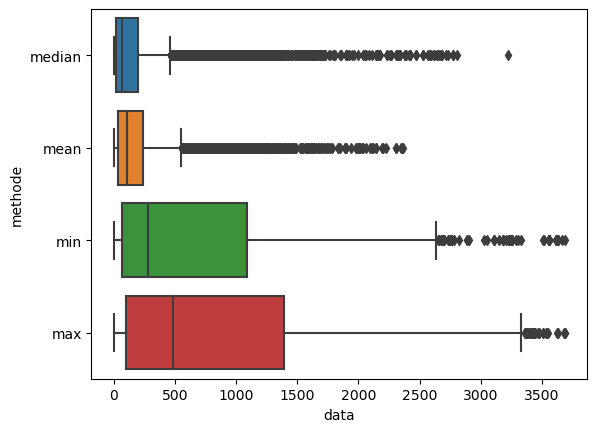

In [60]:
sns.boxplot(data=dataCompare, x='data', y='methode')

### Application de l'algorithme
Estimation de toutes les données nutritionelles selon la mediane de sa categorie

In [61]:
level = 'categorie_level_3'

dataGroup = data.copy()
dataGroup[level] = dataCatFill[level]

for col in ['energy_100g','fat_100g','saturated-fat_100g','omega-3-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g',
'proteins_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g','nutrition-score-fr_100g']:
    colNew = col+'_mean'

    tmpGroup = dataGroup[[level, col]].groupby(by=level).median()

    mask = dataGroup[level].notna() & dataGroup[col].isna()
    data.loc[mask,col] = list(tmpGroup.loc[dataGroup.loc[mask,level], col])

## Prédiction des categories

### Tests des méthodes disponibles

Sélection de la colonne à prédire, on récupère les colonnes contenant des valeurs chiffées, on limite les valeurs NaN, et enfin on en fait deux sets (entrainement et test)

In [62]:
# categories, categories_tags, main_category, main_category_fr, categorie_level_4
columnPredict = 'categorie_level_3'

listeTmp = data.copy()
listeTmp[columnPredict] = dataCatFill[columnPredict]
# Remplacement (en option) des categories classiques par PNNS
listeTmp.loc[data['pnns_groups_2'].notna(), columnPredict] = data.loc[data['pnns_groups_2'].notna(), 'pnns_groups_2']
listeTmp = listeTmp.dropna(subset=columnPredict)


# Liste des colonnes numériques avec plus de 40% de remplissage
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)
listeColumns = list(listeTmp[listeColumns].isna().mean().loc[lambda x : x < 0.6].index)

n = len(listeTmp)
listeTmp = listeTmp[listeColumns + [columnPredict]].dropna()
print(str( 100*(n - len(listeTmp))/n) + "% elements supprimes")
print(len(listeTmp), 'lignes')
print(len(listeColumns), 'colonnes')

X, y = listeTmp[listeColumns], listeTmp[columnPredict]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

40.61444691541059% elements supprimes
7210 lignes
20 colonnes


In [63]:
# Encodage des categories
enc = LabelEncoder().fit(listeTmp[columnPredict])
ytrain = enc.transform(ytrain)
ytest = enc.transform(ytest)

#### K-NN

In [64]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.593620


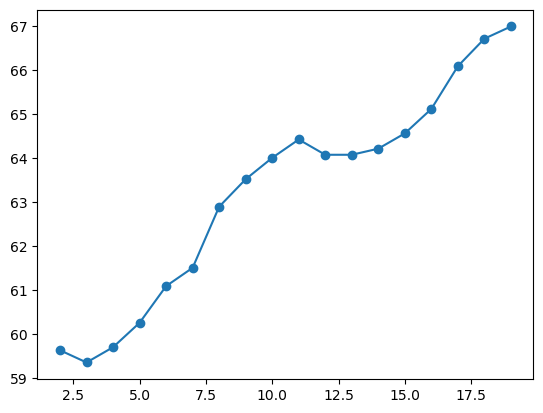

In [65]:
errors = []
for k in range(2,len(listeColumns)):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,len(listeColumns)), errors, 'o-')
plt.show()

#### Arbre de décision

In [66]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(xtrain, ytrain)
error = 1 - clf.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.381415


#### Foret d'arbres de décision

In [67]:
clf = RandomForestClassifier(n_estimators=15)
clf = clf.fit(xtrain, ytrain)
error = 1 - clf.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.268377


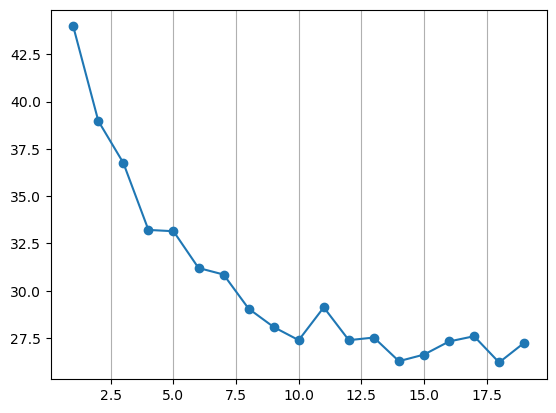

In [68]:
errors = []
for k in range(1,20):
    clf = RandomForestClassifier(n_estimators=k)
    clf = clf.fit(xtrain, ytrain)
    errors.append(100*(1 - clf.score(xtest, ytest)))
plt.plot(range(1, len(errors)+1), errors, 'o-')
plt.grid(axis='x')
plt.show()

### Application de l'algorithme

In [69]:
columnPredict = 'categorie_level_3'

data[columnPredict] = dataCatFill[columnPredict]
data.loc[data['pnns_groups_2'].notna(), columnPredict] = data.loc[data['pnns_groups_2'].notna(), 'pnns_groups_2']

listeTmp = data.loc[~data[columnPredict].isna()]

# Liste des colonnes numériques
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)
listeColumns = list(listeTmp[listeColumns].isna().mean().loc[lambda x : x < 0.6].index)

n = len(listeTmp)
listeTmp = listeTmp[listeColumns + [columnPredict]].dropna()
print(str( 100*(n - len(listeTmp))/n) + "% elements supprimes")
print(len(listeTmp), 'lignes')
print(len(listeColumns), 'colonnes')

X, y = listeTmp[listeColumns], listeTmp[columnPredict]

40.61444691541059% elements supprimes
7210 lignes
20 colonnes


In [70]:
# Encodage des categories
enc = LabelEncoder().fit(y)
y = enc.transform(y)

In [71]:
clf = RandomForestClassifier(n_estimators=15)
clf = clf.fit(X, y)

In [72]:
listeTmp = data.loc[data[columnPredict].isna(), listeColumns]
print("Nombre de lignes sans categorie :", len(listeTmp))
listeTmp = listeTmp.dropna()
print("Nombre de lignes pouvant être prédites :", len(listeTmp))

Nombre de lignes sans categorie : 33713
Nombre de lignes pouvant être prédites : 285


In [73]:
listeTmp[columnPredict] = enc.inverse_transform(clf.predict(listeTmp))

In [74]:
#listeTmp[['code', 'product_name']] = data.loc[listeTmp.index, ['code', 'product_name']]
#listeTmp[ ['code', 'product_name', columnPredict]].head(20)

In [75]:
data[columnPredict] = listeTmp[columnPredict]

In [76]:
data.loc[listeTmp.index, ['code', 'product_name', columnPredict]].head(20)

,code,product_name,categorie_level_3
45350,26049687,foie gras,Meat
4079,8410199006479,"Fritos, Sabor BBQ",Appetizers
35396,5907029000040,Paluszki,Appetizers
18313,5018804900094,Tarama Œufs de Cabillaud,One-dish meals
30001,5060213720541,"Sesame, Honey & Soy Chicken",Fish and seafood
19182,5053947922190,Baked Cracker Mix,Appetizers
6369,9300462103051,Super sweet Corn kernels,Sweetened beverages
48436,01457384,FreeFrom Chocolate Chip Cookies,Biscuits and cakes
4115,7040518520631,helt naturlig jump smoothie,Fruit juices
5484,3396410220488,TARTEX tranches veggie façon nature,Dressings and sauces


In [77]:
data['categories'] = dataCatFill[columnPredict]
data.loc[listeTmp.index, 'categories'] = data.loc[listeTmp.index, columnPredict]

## Test Iterative inputer

In [78]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import *

In [79]:
# Liste des colonnes numériques
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)

In [80]:
# Création d'un dataset troué aléatoirement
listeColumnsHole = listeColumns[:-7]
maskHole = pd.DataFrame(np.random.randint(0,100,data[listeColumnsHole].shape), columns=listeColumnsHole, index=data.index) < 10
dataHole = data[listeColumnsHole].copy()
dataHole = dataHole.mask(maskHole)
dataHole

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
40130,0.0,0.0,0.0,1467.0,NaN,0.400,70.0,3.3,4.2,12.0,0.2540,0.10160,NaN
27264,0.0,0.0,0.0,890.0,17.9,3.675,6.4,4.8,3.2,7.0,0.6350,0.25400,10.5
17964,NaN,0.0,0.0,1600.0,3.0,0.600,78.0,1.5,6.5,10.0,NaN,0.13208,-5.0
48090,1.0,0.0,NaN,1552.0,3.9,2.300,74.6,65.0,9.5,8.2,0.0762,0.03048,11.0
25207,1.0,0.0,NaN,290.0,0.0,0.000,NaN,NaN,0.0,0.6,NaN,0.00400,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12670,NaN,NaN,NaN,NaN,3.0,0.600,65.0,4.0,NaN,12.5,0.0100,0.00400,-6.0
41334,NaN,NaN,NaN,NaN,48.0,5.800,NaN,3.4,NaN,5.3,2.5000,1.00000,20.0
7530,0.0,0.0,0.0,387.0,1.4,0.800,16.7,11.1,0.5,3.0,0.1500,0.06000,2.0
2928,8.0,0.0,1.0,268.0,2.6,0.300,8.4,4.5,0.0,1.7,0.0600,0.02400,-1.0


In [81]:
imp_mean = IterativeImputer(sample_posterior=True, initial_strategy='median')
imp_mean.fit(dataHole)

IterativeImputer(initial_strategy='median', sample_posterior=True)

In [82]:
dataHolePred = imp_mean.transform(dataHole)

In [83]:
dataHoleReal = data[listeColumnsHole].copy().mask(~maskHole)
dataHolePred = pd.DataFrame(dataHolePred, columns=dataHole.columns, index=dataHole.index).mask(dataHoleReal.isna())
dataHoleReal = dataHoleReal.mask(dataHolePred.isna())

listeScore = []
for c in dataHolePred.columns:
    score = r2_score(dataHoleReal[c].dropna(), dataHolePred[c].dropna())
    listeScore += [(c, score)]
    print("Pour la colonne", c, ", l'erreur R² est de :", str(score))

Pour la colonne additives_n , l'erreur R² est de : -0.7484664550882094
Pour la colonne ingredients_from_palm_oil_n , l'erreur R² est de : -0.9266305252580864
Pour la colonne ingredients_that_may_be_from_palm_oil_n , l'erreur R² est de : -0.8603557898604177
Pour la colonne energy_100g , l'erreur R² est de : 0.7714843386619457
Pour la colonne fat_100g , l'erreur R² est de : 0.7589604279803995
Pour la colonne saturated-fat_100g , l'erreur R² est de : 0.09051734954663981
Pour la colonne carbohydrates_100g , l'erreur R² est de : 0.6700239327699488
Pour la colonne sugars_100g , l'erreur R² est de : 0.17849888425320337
Pour la colonne fiber_100g , l'erreur R² est de : -0.5050183099074865
Pour la colonne proteins_100g , l'erreur R² est de : -0.2442206161391114
Pour la colonne salt_100g , l'erreur R² est de : 0.9368659479390442
Pour la colonne sodium_100g , l'erreur R² est de : 0.9406268746056773
Pour la colonne nutrition-score-fr_100g , l'erreur R² est de : 0.36658913581846797


### Application de l'algorithme

In [84]:
# Liste des colonnes numériques
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)

In [85]:
imp_mean = IterativeImputer(sample_posterior=True, initial_strategy='median')
imp_mean.fit(data[listeColumns])

IterativeImputer(initial_strategy='median', sample_posterior=True)

In [86]:
# On ne garde que les lignes avec moins de 40% de valeurs NaN
mask = data[listeColumns].isna().mean(axis=1) < 0.1
dataII = data.loc[mask, listeColumns]
print("On ne garde que", len(dataII), "lignes.")

On ne garde que 26207 lignes.


In [87]:
dataIIPred = pd.DataFrame(imp_mean.transform(dataII), columns=dataII.columns, index=dataII.index)

In [88]:
# Liste des colonnes avec un bon R² score
listeColumnsInteressantes = [c for c, s in listeScore if s>0.6]
print(listeColumnsInteressantes)

['energy_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sodium_100g']


In [89]:
data.loc[mask, listeColumnsInteressantes] = dataIIPred[listeColumnsInteressantes]

# Completion des dernières colonnes

Grade nutriscore

In [90]:
def to_grade(x):
    if x<0:
        return 'a'
    elif x<3:
        return 'b'
    elif x<11:
        return 'c'
    elif x<19:
        return 'd'
    else:
        return 'e'

In [91]:
mask = data['nutrition-score-fr_100g'].notna() & data['nutrition_grade_fr'].isna()

In [92]:
data.loc[mask, 'nutrition_grade_fr'] = data.loc[mask, 'nutrition-score-fr_100g'].apply(to_grade)

# On ne garde que les colonnes utiles

In [93]:
data = data[listeColonesClient + [c for c in listeColonesScore if c not in listeColonesClient]]

# FIN

In [98]:
data.to_csv('./data/data_clean.csv')

<AxesSubplot: >

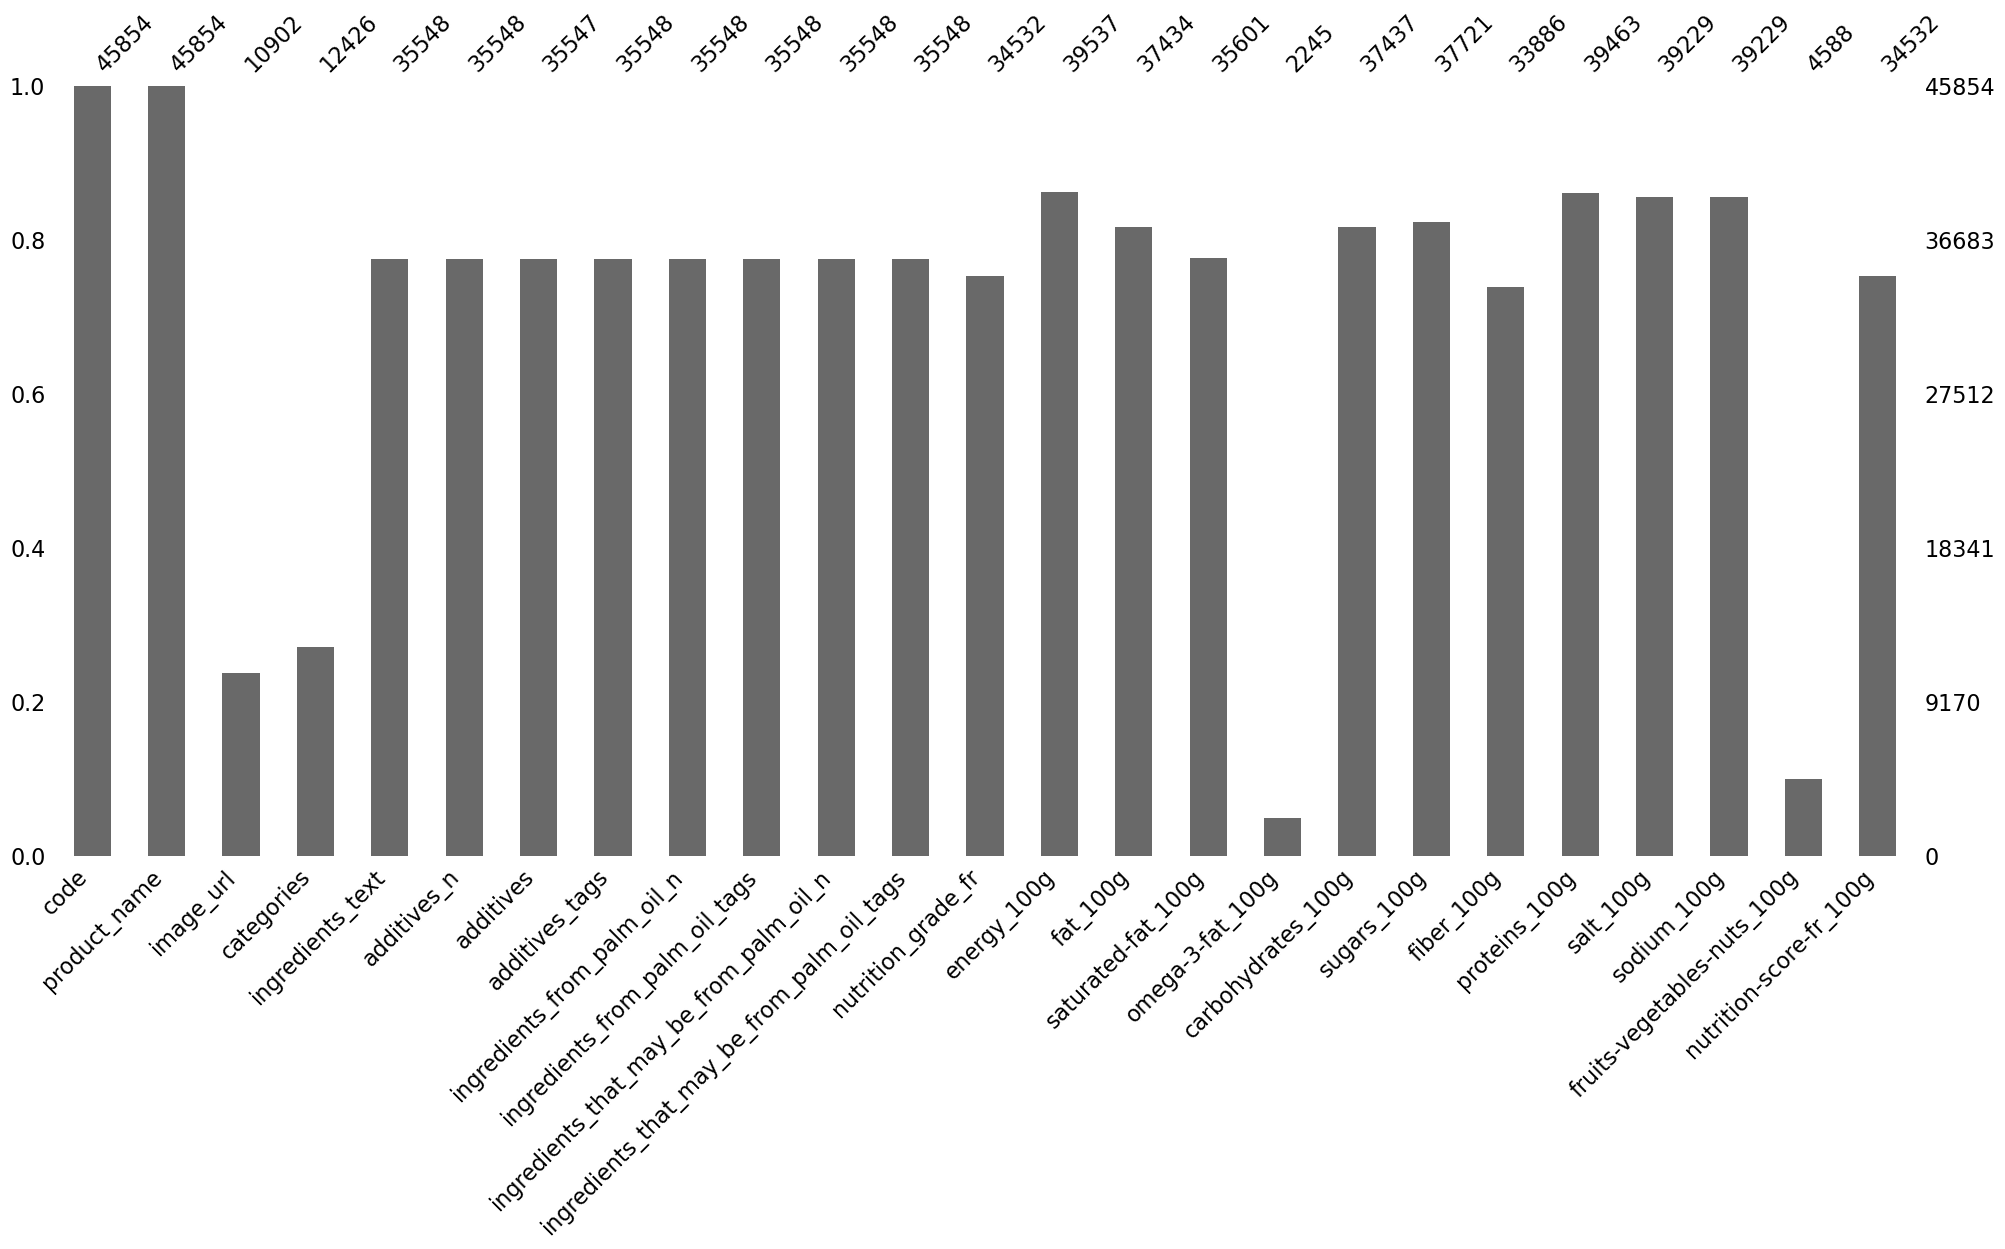

In [94]:
msno.bar(data)

<AxesSubplot: >

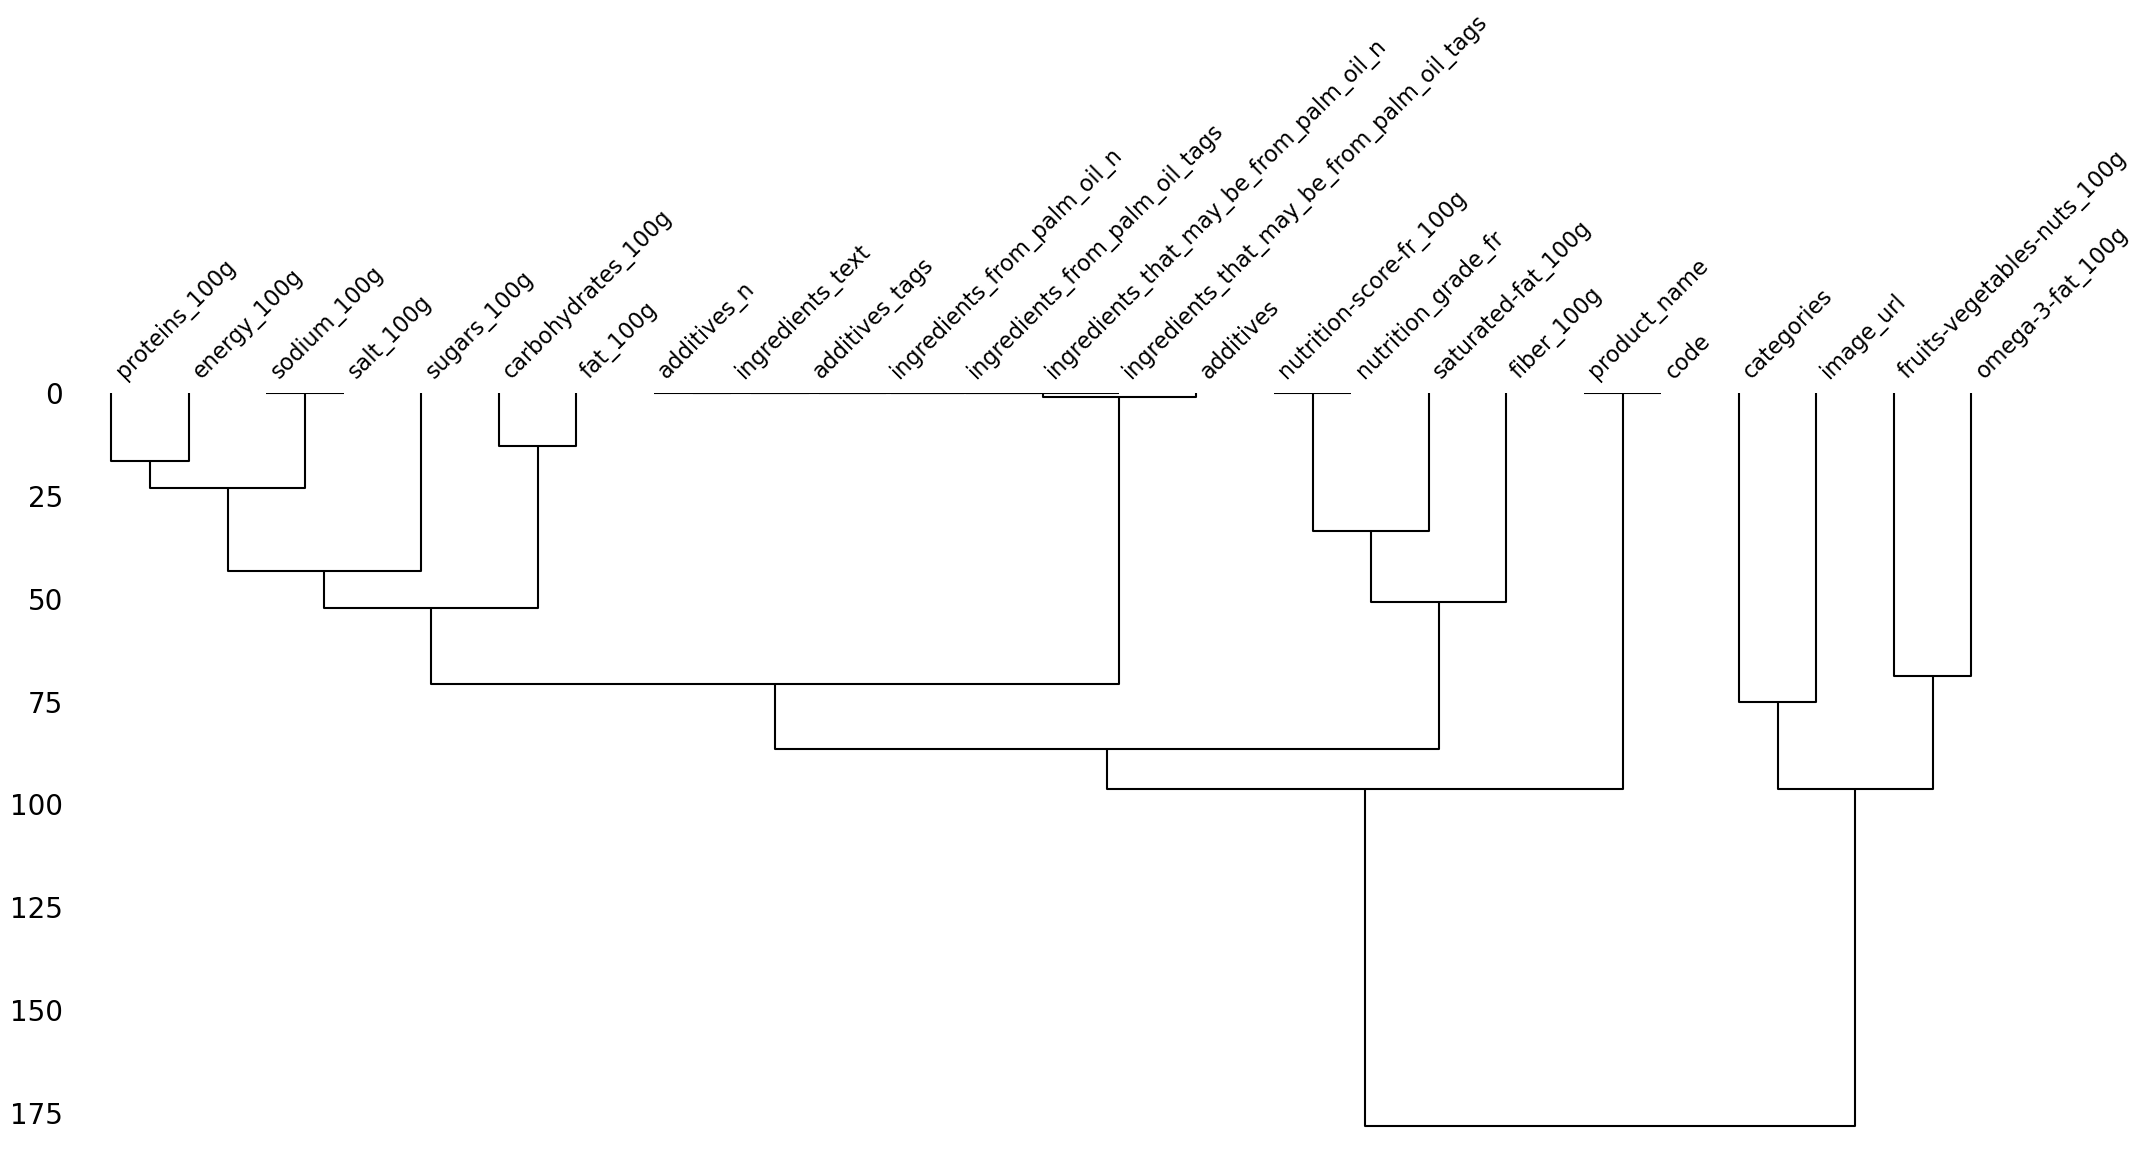

In [95]:
msno.dendrogram(data)

## Verification de l'existence d'additifs

In [96]:
mauvais_additifs = set()
for i in data.index:
    val = data.loc[i, 'additives_tags']
    if val is np.NaN:
        continue
        
    listeA = data.loc[i, 'additives_tags'].split(',')
    for j in range(len(listeA)):
        a = listeA[i][3:]
        if a not in additifs:
            if a[3:-1] not in additifs and a[3:-2] not in additifs:
                pass
            mauvais_additifs.add(a[3:])
            
print(mauvais_additifs)

IndexError: list index out of range

In [ ]:
@interact
def show_articles_more_than(column=[c for c, d in zip(data.columns, data.dtypes) if d != 'object']):
    return data[column].plot.box()

In [ ]:
# Fonction pour détecter combien de colonnes contiennent une valeurs quand l'autre n'en a pas
def same_filling(data, c1, c2, affiche=True):
    mask  = data.loc[:, c1].isna()
    mask ^= data.loc[:, c2].isna()
    
    if not affiche:
        return mask
    
    nb = mask.sum()
    
    print("\nIl y a en tout", nb, "lignes différentes entre", c1, "et", c2, ".")
    if nb>0:
        dataSelect = data.loc[mask]
        print("Sur ces colonnes,", c1, "contient", dataSelect[c1].notna().sum(), "valeurs.")
        print("Et", c2, "contient", dataSelect[c2].notna().sum(), "valeurs.\n")
        print(dataSelect.loc[:, [c1, c2]].head(5))

In [ ]:
# Vérification des incohérences entre les colonnes avec et sans tag
for c in list(data.columns):
    if c.endswith('_tags') and c[:-5] in data.columns:
        same_filling(data, c, c[:-5])

In [ ]:
# Liste des colonnes avec tag
listeTags = pd.Series(data.columns).loc[data.columns.str.endswith('_tags')]

In [ ]:
# Suppression des lignes sans code (impossible à utiliser)
dataClean = data.loc[~dataClean['code'].isna()]
# Et vérification que les codes sont bien uniques (True  = oui)
len(dataClean.loc[dataClean['code'].duplicated()]) == 0

In [ ]:
# Reformate additives et remplis additives_tags
dataClean['additives_tags'] = dataClean['additives'].str.replace(r'\[[^\]>]*> ([a-z]{2}:[a-z0-9\-]+)[^\]]*\] *', r'\1,', regex=True)
dataClean['additives'] = dataClean['additives'].str.replace(r'\[ *([a-z0-9\-]+)[^\[]*', r'\1,', regex=True)

In [ ]:
# Met à NaN toutes les lignes dont tag est NaN (car c'est que la valeur nontag n'est pas valide)
for c1 in listeTags:
    c2 = c1[:-5]
    dataClean.loc[dataClean[c1].isna(), c2] = np.NaN
    if c2 in ['brands']: #Et pour brands on peut même faire l'inverse
        dataClean.loc[dataClean[c2].isna(), c1] = np.NaN

In [ ]:
# Normalise un texte pour en faire un tag
def to_tag(s):
    s = s.lower().strip()
    s = re.sub(r"( +|\')",'\-', s)
    s = re.sub(r'[^\w\s\-]','', s)
    s = unidecode(s)
    return s

In [ ]:
tagToText = {'huile-de-palme': 'Huile de palme'}

# Transforme un tag en texte
def to_text(s):
    oldS = s
    if s in tagToText:
        return tagToText[s]
    
    s = s.replace('-', ' ')
    s = s.capitalize()
    tagToText[oldS] = s
    return s

In [ ]:
# Ajout de la version humaine des tags
for c1 in ['ingredients_that_may_be_from_palm_oil_tags', 'ingredients_from_palm_oil_tags']:
    c2 = c1[:-5]
    mask = same_filling(dataClean, c1, c2, affiche=False)
    
    dataClean.loc[mask, c2] = dataClean.loc[mask, c1].str.split(',').apply(lambda t : ', '.join([to_text(x) for x in t]))

In [ ]:
dataClean.columns

In [ ]:
for c in dataClean.columns:
    if c.endswith('_100g'):
        dataClean[c]

In [ ]:
#dataClean['energy_100g'].plot(kind='box')

min_threshold,max_threshold = dataClean['energy_100g'].quantile([0.01,0.99])
print(min_threshold,max_threshold)

dataClean[(dataClean['energy_100g']<min_threshold)|(dataClean['energy_100g']>max_threshold)][['code', 'fat_100g','energy_100g']].sort_values(by='energy_100g')

In [ ]:
dataClean.loc[:, 'ingredients_from_palm_oil'].str.split(',', expand = True).stack().value_counts().plot(kind='barh', logx=True)

In [ ]:
dataClean['ingredients_that_may_be_from_palm_oil_tags'].str.split(',', expand = True).stack().value_counts().plot(kind='barh', logx=True)

In [ ]:
dataClean.loc[dataClean['brands_tags'].fillna('').str.contains(','), ['brands_tags', 'brands']]